In [78]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [9]:

def make_random_dots(w=600, h=400, n_dots=300, radius=3, bg=(0,0,0)):
    img = np.full((h, w, 3), bg, np.uint8)
    xs = np.random.randint(0, w, n_dots)
    ys = np.random.randint(0, h, n_dots)
    cols = np.random.randint(0, 256, (n_dots, 3), dtype=np.uint8)
    for x, y, c in zip(xs, ys, cols):
        cv.circle(img, (int(x), int(y)), radius, c.tolist(), -1, lineType=cv.LINE_AA)
    return img

def stretch_along_x(img, y_line, amount, decay):
    h, w = img.shape[:2]
    y = np.arange(h, dtype=np.float32)[:, None]
    x = np.arange(w, dtype=np.float32)[None, :]
    influence = np.exp(-((y - y_line) ** 2) / (2 * decay * decay)).astype(np.float32)
    map_x = (x + amount * influence).astype(np.float32)
    map_y = np.repeat(y, w, axis=1).astype(np.float32)
    return cv.remap(img, map_x, map_y, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)


def comb_stretch_along_x(img, n_pins, amount, decay):
    """
    n_pins: number of horizontal 'pins' (lines) across the image height
    amount: max horizontal shift at a pin (pixels, >0 pulls to +x)
    decay: vertical falloff (std dev in pixels) from each pin
    """
    h, w = img.shape[:2]
    y = np.arange(h, dtype=np.float32)[:, None]     # (h,1)
    x = np.arange(w, dtype=np.float32)[None, :]     # (1,w)

    # pin centers (inclusive of top/bottom)
    pins = np.linspace(0, h - 1, n_pins, dtype=np.float32)[:, None]  # (n_pins,1)

    # sum of Gaussian influences from all pins → (h,1)
    d2 = (y[None, :, 0] - pins)**2                    # (n_pins,h)
    influence_rows = np.exp(-d2 / (2 * decay * decay)).sum(axis=0)[:, None]  # (h,1)

    # normalize so max row influence == 1
    max_inf = max(float(influence_rows.max()), 1e-6)
    influence_rows /= max_inf

    map_x = (x + amount * influence_rows).astype(np.float32)  # broadcast to (h,w)
    map_y = np.repeat(np.arange(h, dtype=np.float32)[:, None], w, axis=1)

    return cv.remap(img, map_x, map_y, interpolation=cv.INTER_LINEAR,
                    borderMode=cv.BORDER_CONSTANT)



In [42]:
def make_palette_dots(w=600, h=400, n_dots=300, radius=3,
                      palette=((255,0,0),(0,255,0),(0,0,255)),  # RGB tuples
                      probs=None, bg=(0,0,0)):
    """
    palette : iterable of RGB tuples in [0..255]
    probs   : optional probabilities (same length as palette); will be normalized
    """
    img = np.full((h, w, 3), bg, np.uint8)

    # choose colors only from the given palette
    k = len(palette)
    if probs is None:
        idx = np.random.randint(0, k, size=n_dots)
    else:
        p = np.asarray(probs, dtype=np.float64)
        p = p / p.sum()
        idx = np.random.choice(k, size=n_dots, p=p)

    cols_rgb = np.asarray(palette, dtype=np.uint8)[idx]        # (n_dots,3) RGB
    cols_bgr = cols_rgb[:, ::-1]                               # OpenCV uses BGR

    xs = np.random.randint(0, w, n_dots)
    ys = np.random.randint(0, h, n_dots)

    for (x, y, c) in zip(xs, ys, cols_bgr):
        cv.circle(img, (int(x), int(y)), int(radius), c.tolist(), -1, lineType=cv.LINE_AA)

    return img


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [69]:
import numpy as np
import cv2 as cv

def comb_stretch(img, n_pins, amount, decay, direction="right",  phase=0.0):
    h, w = img.shape[:2]
    x = np.arange(w, dtype=np.float32)[None, :]   # (1,w)
    y = np.arange(h, dtype=np.float32)[None, :]   # (1,h)

    dirs = {"right": (+1, "x"), "left": (-1, "x"), "down": (-1, "y"), "up": (1, "y")}
    sgn, axis = dirs[direction]

    if axis == "x":
        # horizontal pins across height → shift along x
        pins = np.linspace(0, h - 1, n_pins, dtype=np.float32)[:, None] + phase * (h / n_pins)  # (n_pins,1)
        d = y - pins                                               # (n_pins,h)
        d2 = (y - pins) ** 2                                            # (n_pins,h)
        #infl_rows = np.exp(-d2 / (2*decay*decay)).sum(axis=0)[None, :]  # (1,h)
        infl_rows = np.exp(-np.abs(d) / decay).sum(axis=0)[None, :]  # (1, h)
        infl_rows /= max(float(infl_rows.max()), 1e-6)
        map_x = (x + sgn * amount * infl_rows.T).astype(np.float32)     # (h,1)+(1,w)->(h,w)
        map_y = np.repeat(y.T, w, axis=1).astype(np.float32)            # (h,w)
    else:
        # vertical pins across width → shift along y
        pins = np.linspace(0, w - 1, n_pins, dtype=np.float32)[:, None] + phase * (w / n_pins)  # (n_pins,1)
        d = (x - pins)                                               # (n_pins,w)
        d2 = (x - pins) ** 2                                            # (n_pins,w)
        #infl_cols = np.exp(-d2 / (2*decay*decay)).sum(axis=0)[None, :]  # (1,w)
        infl_cols = np.exp(-np.abs(d) / decay).sum(axis=0)[None, :]  # (1, w)
        infl_cols /= max(float(infl_cols.max()), 1e-6)
        map_x = np.repeat(x, h, axis=0).astype(np.float32)              # (h,w)
        map_y = (y.T + sgn * amount * infl_cols).astype(np.float32)     # (h,1)+(1,w)->(h,w)

    return cv.remap(img, map_x, map_y, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)


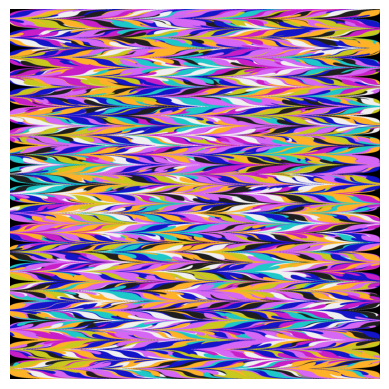

In [80]:
#img = make_random_dots(1000, 1000, 1000, radius=30)
img = make_palette_dots(2000, 2000, 10000, radius=40,
                        palette=((214,102,244),(255,177, 40),(20,20,200),(200,200,30),(30,200,200),(200,30,200), (240,240,240), (30,30,30)),
                        probs=(1,1,1,0.5,0.5,0.5, 0.5, 0.5),
                        bg=(10,10,10))
out = img.copy()
#out = stretch_along_x(img, y_line=200, amount=80, decay=60)
#out = comb_stretch_along_x(img, n_pins=6, amount=80, decay=8)
out = comb_stretch(out, n_pins=20, amount=80, decay=8, direction="left")
out = comb_stretch(out, n_pins=20, amount=80, decay=8, direction="right", phase=0.5)
out = comb_stretch(out, n_pins=20, amount=80, decay=8, direction="left")
out = comb_stretch(out, n_pins=20, amount=80, decay=8, direction="right", phase=0.5)


plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

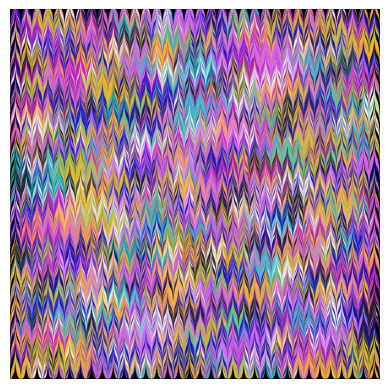

In [81]:
# zig zag
out = comb_stretch(out, n_pins=35, amount=80, decay=6, direction="down")
out = comb_stretch(out, n_pins=35, amount=80, decay=6, direction="up", phase=0.5)

plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

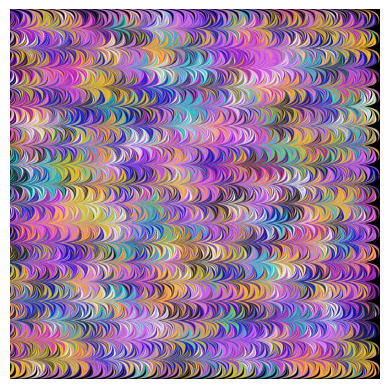

In [82]:
out = comb_stretch(out, n_pins=20, amount=80, decay=12, direction="right")

plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

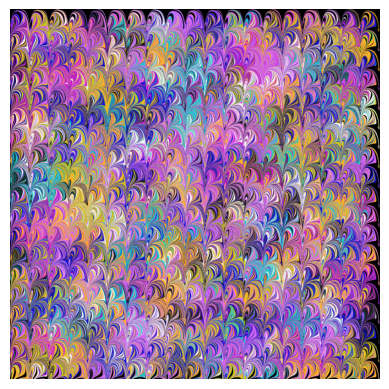

In [83]:
out = comb_stretch(out, n_pins=20, amount=80, decay=12, direction="down")

plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [84]:
cv.imwrite("dots.png", img)
cv.imwrite("dots_stretched.png", out)

True